In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

import tifffile as tif

import xarray as xr
import os

from collections import defaultdict
from itertools import islice
import random

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import math

In [2]:
sar_dir = '/data/exjobb/sarssw/sar_multiprocess/'   
bouy_survey_dir = '../bouy_survey/1h_survey/result_df'
svc_dir = './out/homogenity_svc.pkl'

with open(svc_dir, 'rb') as f: svc = pickle.load(f)
with open(bouy_survey_dir,'rb') as f_r: bouy_survey_df = pickle.load(f_r)
    
bouy_survey_df['sar_name'] = bouy_survey_df['sar_url'].apply(lambda row: row.split('/')[-1].split('.')[0])
bouy_survey_df['bouy_name'] = bouy_survey_df['bouy_file_name'].apply(lambda row: row.split('.')[0])
bouy_survey_df = bouy_survey_df.set_index(['sar_name', 'bouy_name']).sort_index()

/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# for getting the sigma0
def sar_gen(sar_dir, only_center = False, hom = True):
    sar_files = os.listdir(sar_dir)
    for file_name in sar_files:
        if not file_name.endswith('.tif'): continue
            
        if only_center:
            if not file_name.split('.')[0][-1] == '0': continue
                
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            for v in tif_img.asarray():   
                #print(tif_img.shaped_metadata[0])
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)

                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                pred = svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]])[0]
                if pred == (0 if hom else 1):
                    yield v

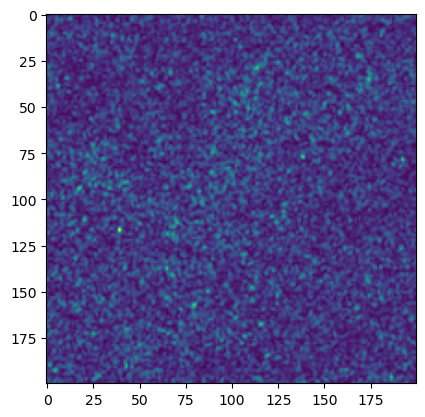

In [5]:
sigma0 = next(sar_gen(sar_dir))
plt.imshow(sigma0)
plt.show()

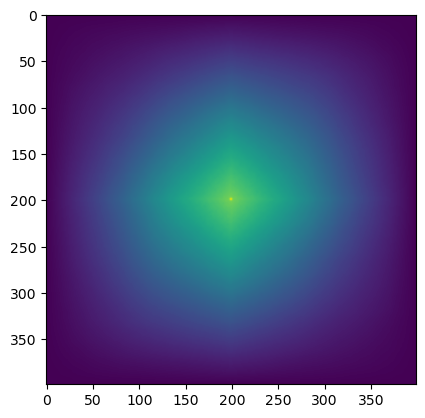

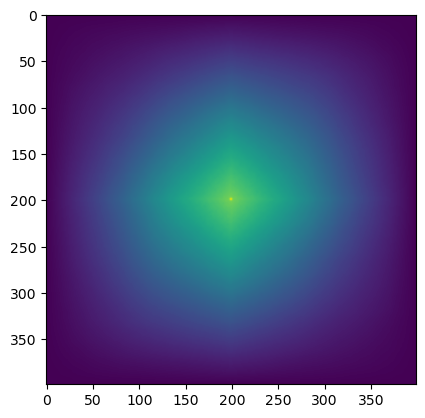

Azimuth cutoff frequency: 848.4848484848486


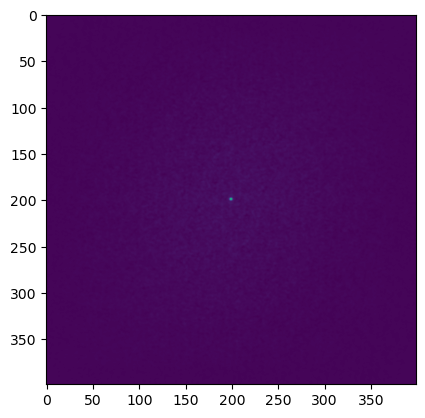

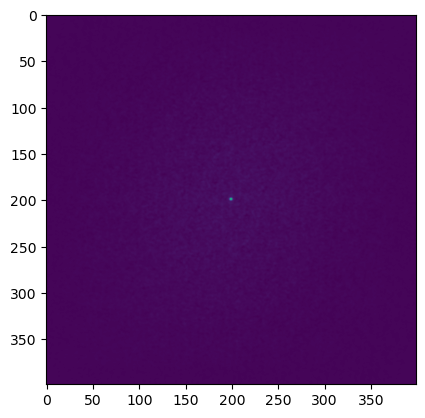

Azimuth cutoff frequency: 31818.18181818182


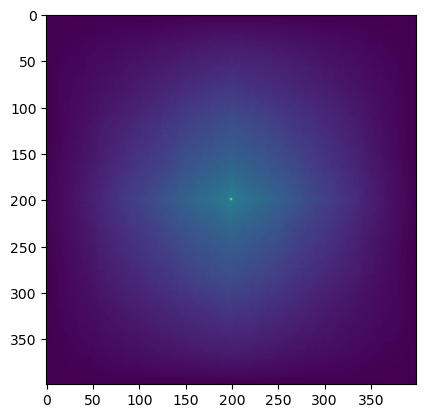

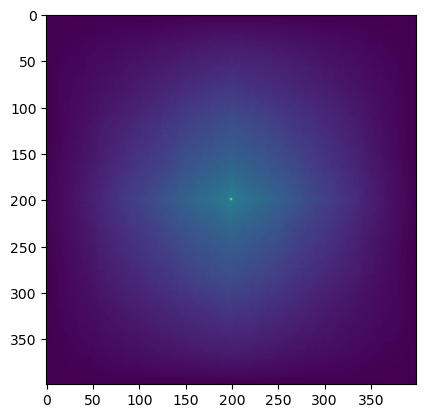

Azimuth cutoff frequency: 31818.18181818182


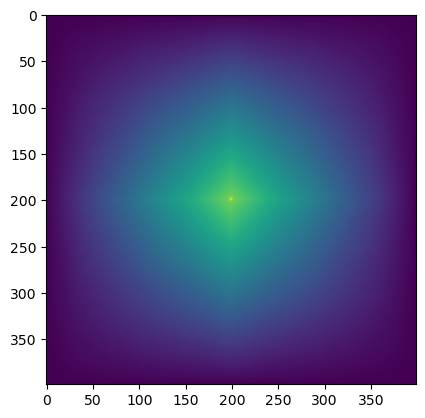

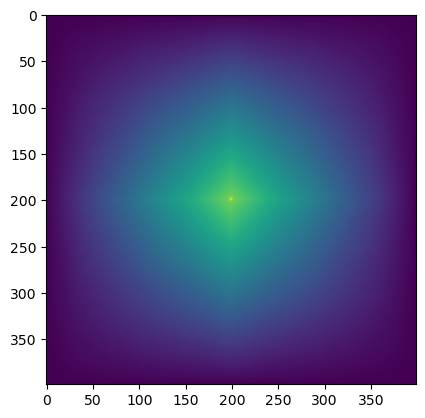

Azimuth cutoff frequency: 859.9508599508599


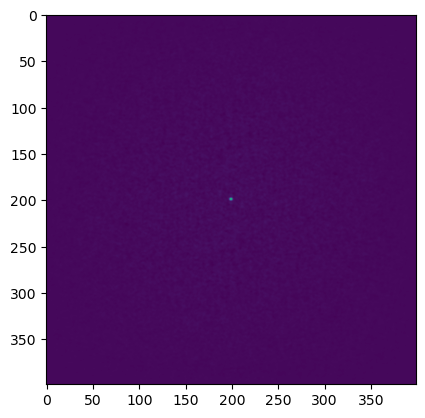

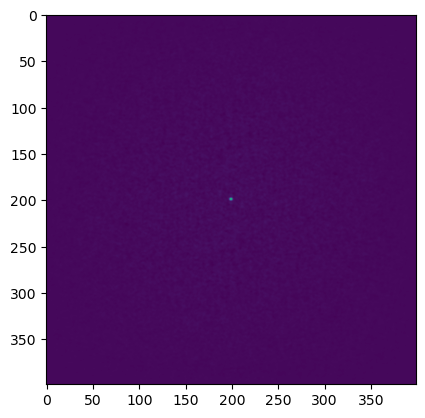

Azimuth cutoff frequency: 31818.18181818182


In [35]:

images = list(islice(sar_gen(sar_dir), 5))

for data in images:
    acf = scipy.signal.correlate2d(data, data, mode='full', boundary='fill', fillvalue=0)
    plt.imshow(acf)
    plt.show()
    acf = acf / np.max(acf)  # Normalize the ACF
    plt.imshow(acf)
    plt.show()
    center = np.array(acf.shape) // 2
    half_max = 0.5
    azimuth_acf = acf[center[0], center[1]:]
    half_max_idx = np.where(azimuth_acf < half_max)[0][0]
    fwhm = half_max_idx * 2
    k_ac = 1 / fwhm
    # You need to fill in the values for V and Lambda
    V = 7_000  # Platform velocity (m/s) - fill in the value for Sentinel-1
    Lambda = 0.055  # Radar wavelength (m) - fill in the value for Sentinel-1

    f_ac = (V * k_ac) / Lambda
    
    print(f'Azimuth cutoff frequency: {f_ac}')

In [30]:
import scipy.signal

images = list(islice(sar_gen(sar_dir), 10))

for data in images:
    acf = scipy.signal.correlate2d(data, data, mode='full', boundary='fill', fillvalue=0)
    acf = acf / np.max(acf)  # Normalize the ACF
    center = np.array(acf.shape) // 2
    half_max = 0.5
    azimuth_acf = acf[center[0], center[1]:]
    half_max_idx = np.where(azimuth_acf < half_max)[0][0]
    fwhm = half_max_idx * 2
    k_ac = 1 / fwhm
    # You need to fill in the values for V and Lambda
    V = 7_000  # Platform velocity (m/s) - fill in the value for Sentinel-1
    Lambda = 0.055  # Radar wavelength (m) - fill in the value for Sentinel-1

    f_ac = (V * k_ac) / Lambda
    
    print(f'Azimuth cutoff frequency: {f_ac}')

Azimuth cutoff frequency: 848.4848484848486
Azimuth cutoff frequency: 31818.18181818182
Azimuth cutoff frequency: 31818.18181818182
Azimuth cutoff frequency: 859.9508599508599
Azimuth cutoff frequency: 31818.18181818182
Azimuth cutoff frequency: 922.266139657444
Azimuth cutoff frequency: 31818.18181818182
Azimuth cutoff frequency: 871.73100871731
Azimuth cutoff frequency: 31818.18181818182
Azimuth cutoff frequency: 31818.18181818182


In [36]:
import scipy.optimize

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

images = list(islice(sar_gen(sar_dir), 10))

for data in images:
    acf = scipy.signal.correlate2d(data, data, mode='full', boundary='fill', fillvalue=0)
    acf = acf / np.max(acf)  # Normalize the ACF
    center = np.array(acf.shape) // 2
    azimuth_acf = acf[center[0], center[1]:]

    # Initial guess for Gaussian parameters
    initial_params = [1.0, 0, 10]

    # Fit the Gaussian function
    fitted_params, _ = scipy.optimize.curve_fit(gaussian, np.arange(azimuth_acf.size), azimuth_acf, p0=initial_params)
    amplitude, mean, stddev = fitted_params

    fwhm = 2 * np.sqrt(2 * np.log(2)) * stddev
    k_ac = 1 / fwhm

    # You need to fill in the values for V and Lambda
    V = 7_000  # Platform velocity (m/s) - fill in the value for Sentinel-1
    Lambda = 0.055  # Radar wavelength (m) - fill in the value for Sentinel-1

    f_ac = (V * k_ac) / Lambda
    
    print(f'Azimuth cutoff frequency: {f_ac}')



Azimuth cutoff frequency: 542.501881050128
Azimuth cutoff frequency: 50269.25603843856
Azimuth cutoff frequency: 404.3906914543726
Azimuth cutoff frequency: 500.3757971857801
Azimuth cutoff frequency: 53981.12603584381
Azimuth cutoff frequency: 510.2309597141924
Azimuth cutoff frequency: 54153.22887727449
Azimuth cutoff frequency: 530.7619070246319
Azimuth cutoff frequency: 50748.52543941784
Azimuth cutoff frequency: 50729.512683618625


In [37]:

images = list(islice(sar_gen(sar_dir), 10))

for data in images:
    acf = scipy.signal.correlate2d(data, data, mode='full', boundary='fill', fillvalue=0)
    acf = acf / np.max(acf)  # Normalize the ACF
    center = np.array(acf.shape) // 2
    azimuth_acf = acf[center[0], center[1]:]
    x = np.arange(azimuth_acf.size)
    y = np.log(azimuth_acf)

    # Fit a quadratic function to the logarithm of the data
    coefficients = np.polyfit(x, y, deg=2)

    # Calculate the fitted Gaussian parameters from the quadratic coefficients
    amplitude = np.exp(coefficients[2])
    mean = -coefficients[1] / (2 * coefficients[0])
    stddev = np.sqrt(-1 / (2 * coefficients[0]))

    fwhm = 2 * np.sqrt(2 * np.log(2)) * stddev
    k_ac = 1 / fwhm

    # You need to fill in the values for V and Lambda
    V = 7_000  # Platform velocity (m/s) - fill in the value for Sentinel-1
    Lambda = 0.055  # Radar wavelength (m) - fill in the value for Sentinel-1

    f_ac = (V * k_ac) / Lambda
    
    print(f'Azimuth cutoff frequency: {f_ac}')

Azimuth cutoff frequency: 834.202464792257
Azimuth cutoff frequency: nan


/tmp/ipykernel_476/4163570740.py:9: RuntimeWarning: invalid value encountered in log
  y = np.log(azimuth_acf)


Azimuth cutoff frequency: 819.4528417044284
Azimuth cutoff frequency: 819.2642647073824
Azimuth cutoff frequency: nan
Azimuth cutoff frequency: 825.1506060181687
Azimuth cutoff frequency: nan
Azimuth cutoff frequency: 839.4337474170964
Azimuth cutoff frequency: nan
Azimuth cutoff frequency: nan


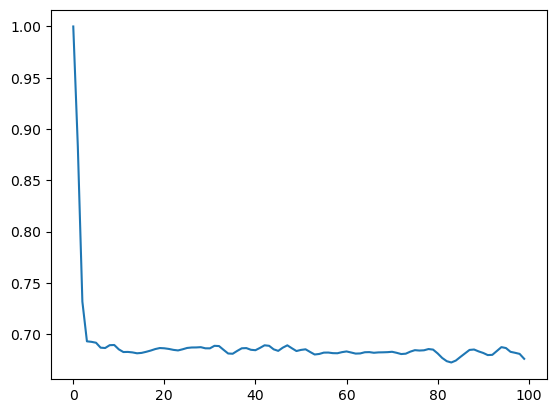

In [51]:
plt.plot(azimuth_acf)

In [48]:
import numpy as np
from itertools import islice
from scipy.stats import norm

def acf_wiener_khinchin(data):
    psd = np.abs(np.fft.fft2(data)) ** 2
    acf = np.fft.ifft2(psd)
    acf = np.fft.fftshift(acf)
    acf = np.real(acf)
    return acf

for data in islice(sar_gen(sar_dir), 100):
    acf = acf_wiener_khinchin(data)
    acf = acf / np.max(acf)  # Normalize the ACF
    center = np.array(acf.shape) // 2
    azimuth_acf = acf[center[0], center[1]:]

    fwhm = 2 * np.sqrt(2 * np.log(2)) * azimuth_acf.std()

    k_ac = 1 / fwhm

    # Define values for V and Lambda for your specific SAR system
    V = 7_000  # Platform velocity (m/s)
    Lambda = 0.056  # Radar wavelength (m) for Sentinel-1 C-band

    f_ac = (V * k_ac) / Lambda
    
    print(f'Azimuth cutoff frequency: {f_ac}')

0.02575765099044287
0.02575765099044287
Azimuth cutoff frequency: 2060848.3490088822
0.11226867514064502
0.11226867514064502
Azimuth cutoff frequency: 472817.6621974183
0.0698728741106961
0.0698728741106961
Azimuth cutoff frequency: 759702.7200270173
0.025450709008944545
0.025450709008944545
Azimuth cutoff frequency: 2085702.7008302803
0.1160134295361566
0.1160134295361566
Azimuth cutoff frequency: 457555.7565209081
0.02780744438260258
0.02780744438260258
Azimuth cutoff frequency: 1908935.3119847195
0.11355430429563138
0.11355430429563138
Azimuth cutoff frequency: 467464.55669178336
0.025451880590190355
0.025451880590190355
Azimuth cutoff frequency: 2085606.693379673
0.11237176449380107
0.11237176449380107
Azimuth cutoff frequency: 472383.901393036
0.11682150396340245
0.11682150396340245
Azimuth cutoff frequency: 454390.76468858664
0.03275349891007728
0.03275349891007728
Azimuth cutoff frequency: 1620669.982884462
0.09221630169750353
0.09221630169750353
Azimuth cutoff frequency: 575631

In [151]:
help(np.convolve)

Help on function convolve in module numpy:

convolve(a, v, mode='full')
    Returns the discrete, linear convolution of two one-dimensional sequences.
    
    The convolution operator is often seen in signal processing, where it
    models the effect of a linear time-invariant system on a signal [1]_.  In
    probability theory, the sum of two independent random variables is
    distributed according to the convolution of their individual
    distributions.
    
    If `v` is longer than `a`, the arrays are swapped before computation.
    
    Parameters
    ----------
    a : (N,) array_like
        First one-dimensional input array.
    v : (M,) array_like
        Second one-dimensional input array.
    mode : {'full', 'valid', 'same'}, optional
        'full':
          By default, mode is 'full'.  This returns the convolution
          at each point of overlap, with an output shape of (N+M-1,). At
          the end-points of the convolution, the signals do not overlap
          co

In [180]:
example_crop = xr.open_dataset('/data/exjobb/sarssw/sar_multiprocess2/' + os.listdir('/data/exjobb/sarssw/sar_multiprocess2')[0])

In [189]:
example_crop

<xarray.Dataset>
Dimensions:    (line: 200, sample: 200, pol: 2)
Coordinates:
  * line       (line) int32 15346 15347 15348 15349 ... 15542 15543 15544 15545
  * sample     (sample) int32 8351 8352 8353 8354 8355 ... 8547 8548 8549 8550
  * pol        (pol) object 'VV' 'VH'
Data variables:
    incidence  (line, sample) float64 ...
    velocity   (line) float64 ...
    sigma0     (pol, line, sample) float64 0.265 0.1793 ... 0.003552 0.002501
Attributes: (12/13)
    safe:              S1A_IW_GRDH_1SDV_20210919T161305_20210919T161330_03975...
    swath:             IW
    platform:          SENTINEL-1A
    orbit_pass:        Ascending
    product:           GRDH
    platform_heading:  -17.30042045081396
    ...                ...
    bouy_name:         BO_TS_MO_NorthernBaltic
    polarisations:     VV VH
    longitude:         21.007191663873037
    latitude:          59.2554603180096
    time:              2021-09-19T16:13:28.250408448
    subimage_index:    2

In [194]:
help(xr.Dataset.mean)

Help on function mean in module xarray.core._aggregations:

mean(self, dim: 'Dims' = None, *, skipna: 'bool | None' = None, keep_attrs: 'bool | None' = None, **kwargs: 'Any') -> 'Dataset'
    Reduce this Dataset's data by applying ``mean`` along some dimension(s).
    
    Parameters
    ----------
    dim : str, Iterable of Hashable, "..." or None, default: None
        Name of dimension[s] along which to apply ``mean``. For e.g. ``dim="x"``
        or ``dim=["x", "y"]``. If "..." or None, will reduce over all dimensions.
    skipna : bool or None, optional
        If True, skip missing values (as marked by NaN). By default, only
        skips missing values for float dtypes; other dtypes either do not
        have a sentinel missing value (int) or ``skipna=True`` has not been
        implemented (object, datetime64 or timedelta64).
    keep_attrs : bool or None, optional
        If True, ``attrs`` will be copied from the original
        object to the new one.  If False, the new obje

In [207]:
example_crop.sel(pol='VV').mean(dim='line').sigma0.values

array([0.13446282, 0.13190843, 0.1420535 , 0.14256628, 0.14116187,
       0.13216556, 0.11969304, 0.11931727, 0.12513975, 0.13237068,
       0.14501604, 0.14762941, 0.13744432, 0.12794535, 0.1308095 ,
       0.14184069, 0.13832462, 0.13799298, 0.14261885, 0.14665964,
       0.13834893, 0.12962843, 0.13750028, 0.14005879, 0.13256253,
       0.1439715 , 0.14690865, 0.13379389, 0.12793376, 0.12546271,
       0.12111663, 0.12598629, 0.12630512, 0.12727205, 0.15443546,
       0.15862524, 0.15039829, 0.13450104, 0.12128385, 0.11738058,
       0.12352687, 0.12063179, 0.12889851, 0.13491625, 0.13725373,
       0.15368284, 0.1541866 , 0.13697881, 0.1309885 , 0.12442907,
       0.1261192 , 0.12822397, 0.13097659, 0.13508029, 0.14878422,
       0.15621737, 0.14506065, 0.13578976, 0.12733026, 0.12715755,
       0.12423253, 0.12580476, 0.13591059, 0.15549949, 0.1554871 ,
       0.13478216, 0.13146955, 0.12090642, 0.10584722, 0.10356421,
       0.11446911, 0.13226199, 0.16277904, 0.18811483, 0.18435

In [230]:
example_crop.sel(pol='VV').sigma0.dims.index('sample')

1

In [220]:
example_crop.sel(pol='VV').mean(dim='sample')

<xarray.Dataset>
Dimensions:    (line: 200)
Coordinates:
  * line       (line) int32 15346 15347 15348 15349 ... 15542 15543 15544 15545
    pol        <U2 'VV'
Data variables:
    incidence  (line) float64 35.53 35.53 35.53 35.53 ... 35.53 35.53 35.53
    velocity   (line) float64 7.587e+03 7.587e+03 ... 7.587e+03 7.587e+03
    sigma0     (line) float64 0.1168 0.1173 0.12 0.1214 ... 0.1264 0.1322 0.1342

In [225]:
example_crop.sel(pol='VV').mean(dim='sample').sigma0.values == example_crop.sel(pol='VV').sigma0.values.mean(axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [191]:
# varying sample                                  varying row
# fixed line.                                      fixed col
np.all(example_crop.isel(line=0).sigma0.values == example_crop.sigma0.values[:,0])

True

In [213]:
example_crop.sel(pol='VV').isel(line=0).sigma0.values.mean(), example_crop.sel(pol='VV').sigma0.values.mean(axis=1)[0]

(0.11678410912983787, 0.11678410912983787)

In [222]:
np.random.rand(5,10).mean(axis=1).shape

(5,)

/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asa

Azimuth cutoff wavelength = 1.90557
Azimuth cutoff wavelength = 0.17227
Azimuth cutoff wavelength = 0.24301
Azimuth cutoff wavelength = 2.80629
Azimuth cutoff wavelength = 0.21574
Azimuth cutoff wavelength = 0.83674
Azimuth cutoff wavelength = 0.14734
Azimuth cutoff wavelength = 1.95440
Azimuth cutoff wavelength = 0.21681
Azimuth cutoff wavelength = 0.23849
Azimuth cutoff wavelength = 0.54730
Azimuth cutoff wavelength = 0.13182
Azimuth cutoff wavelength = 1.96432
Azimuth cutoff wavelength = 0.18875
Azimuth cutoff wavelength = 0.10058
Azimuth cutoff wavelength = 3.31251
Azimuth cutoff wavelength = 0.24099
Azimuth cutoff wavelength = 4.08401
Azimuth cutoff wavelength = 0.22032
Azimuth cutoff wavelength = 1.23454
Azimuth cutoff wavelength = 0.15579


/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asa

Azimuth cutoff wavelength = 2.50798
Azimuth cutoff wavelength = 0.20251
Azimuth cutoff wavelength = 1.67490
Azimuth cutoff wavelength = 0.14497
Azimuth cutoff wavelength = 1.33344
Azimuth cutoff wavelength = 0.12252
Azimuth cutoff wavelength = 1.86842
Azimuth cutoff wavelength = 1.88341
Azimuth cutoff wavelength = 0.18399
Azimuth cutoff wavelength = 0.12880
Azimuth cutoff wavelength = 1.02816
Azimuth cutoff wavelength = 1.35914
Azimuth cutoff wavelength = 0.15714
Azimuth cutoff wavelength = 2.30506
Azimuth cutoff wavelength = 0.27055
Azimuth cutoff wavelength = 1.61797
Azimuth cutoff wavelength = 0.18206


/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asa

Azimuth cutoff wavelength = 1.57497
Azimuth cutoff wavelength = 0.12078
Azimuth cutoff wavelength = 2.02211
Azimuth cutoff wavelength = 0.18108
Azimuth cutoff wavelength = 0.22350
Azimuth cutoff wavelength = 2.84145
Azimuth cutoff wavelength = 0.32192
Azimuth cutoff wavelength = 1.98911
Azimuth cutoff wavelength = 3.55442
Azimuth cutoff wavelength = 0.29829
Azimuth cutoff wavelength = 1.31384
Azimuth cutoff wavelength = 0.15659
Azimuth cutoff wavelength = 1.69357
Azimuth cutoff wavelength = 0.25398
Azimuth cutoff wavelength = 1.10144
Azimuth cutoff wavelength = 0.20178
Azimuth cutoff wavelength = 1.20180
Azimuth cutoff wavelength = 0.14958
Azimuth cutoff wavelength = 0.95138
Azimuth cutoff wavelength = 0.14913
Azimuth cutoff wavelength = 0.07465
Azimuth cutoff wavelength = 2.25517
Azimuth cutoff wavelength = 0.22012
Azimuth cutoff wavelength = 0.80303
Azimuth cutoff wavelength = 0.10257


/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asa

Azimuth cutoff wavelength = 5.22259
Azimuth cutoff wavelength = 0.16943
Azimuth cutoff wavelength = 5.08746
Azimuth cutoff wavelength = 0.28327
Azimuth cutoff wavelength = 0.93125
Azimuth cutoff wavelength = 0.14992
Azimuth cutoff wavelength = 1.43057
Azimuth cutoff wavelength = 0.09180
Azimuth cutoff wavelength = 0.66847
Azimuth cutoff wavelength = 0.17176
Azimuth cutoff wavelength = 3.48586
Azimuth cutoff wavelength = 0.23956
Azimuth cutoff wavelength = 1.24336
Azimuth cutoff wavelength = 0.20865
Azimuth cutoff wavelength = 0.92412
Azimuth cutoff wavelength = 0.23258
Azimuth cutoff wavelength = 5.09149
Azimuth cutoff wavelength = 0.15077
Azimuth cutoff wavelength = 1.49863
Azimuth cutoff wavelength = 0.14526
Azimuth cutoff wavelength = 0.18760


/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asa

Azimuth cutoff wavelength = 2.77498
Azimuth cutoff wavelength = 0.21951
Azimuth cutoff wavelength = 0.95802
Azimuth cutoff wavelength = 0.09184
Azimuth cutoff wavelength = 5.07559
Azimuth cutoff wavelength = 0.31217
Azimuth cutoff wavelength = 0.58898
Azimuth cutoff wavelength = 0.14339
Azimuth cutoff wavelength = 0.82991
Azimuth cutoff wavelength = 0.10166
Azimuth cutoff wavelength = 0.82057
Azimuth cutoff wavelength = 0.14087
Azimuth cutoff wavelength = 2.74798
Azimuth cutoff wavelength = 0.21885
Azimuth cutoff wavelength = 0.12111
Azimuth cutoff wavelength = 0.59475


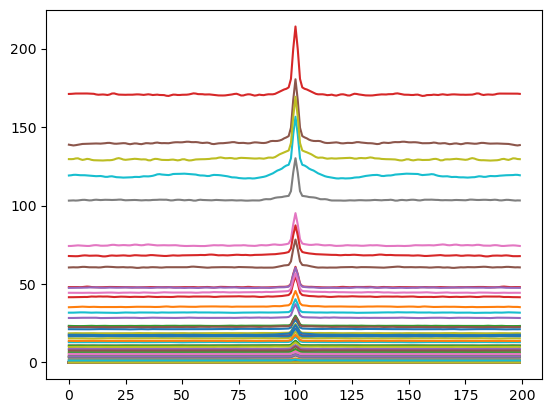

In [236]:
import numpy as np
from itertools import islice

for sigma0 in islice(sar_gen(sar_dir), 100):
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    psd = psd.mean(axis=1)
    acf = np.fft.ifft(psd)
    acf = np.fft.fftshift(acf)
    #acf = np.abs(acf)
    #acf = (acf - np.min(acf)) / (np.max(acf) - np.min(acf))
    
    #acf = np.convolve(acf, np.ones(7)/7, mode='same')
    
    plt.plot(acf)
    #fwhm = 2 * np.sqrt(2 * np.log(2)) * acf.std()
    fwhm = np.sqrt(2 * np.pi * acf.std())

    # Print the approximated azimuth cutoff wavelength
    print(f"Azimuth cutoff wavelength = {fwhm:.5f}")

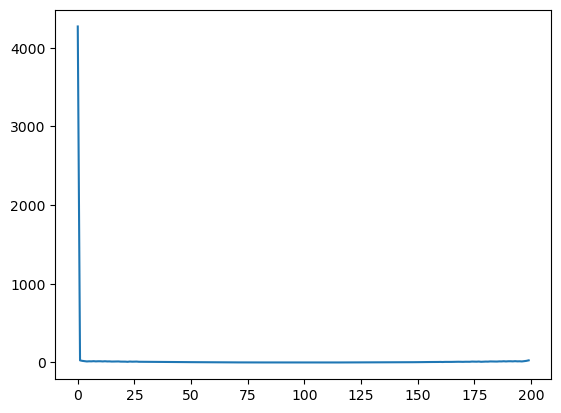

In [171]:
sigma0 = next(sar_gen(sar_dir))
plt.plot((np.abs(np.fft.fft2(sigma0)) ** 2).mean(axis=1))

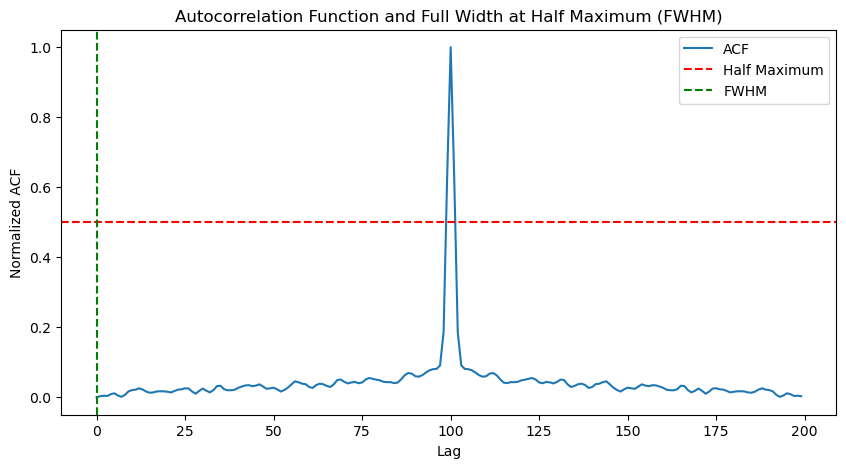

Azimuth cutoff wavelength (FWHM) = 0.21896


In [134]:
sigma0 = next(sar_gen(sar_dir))
psd = np.abs(np.fft.fft2(sigma0)) ** 2
psd = psd.mean(axis=0)
acf = np.fft.ifft(psd)
acf = np.fft.fftshift(acf)
acf = np.real(acf)
acf = (acf - np.min(acf)) / (np.max(acf) - np.min(acf))

#acf = np.convolve(acf, np.ones(7)/7, mode='same')

fwhm = 2 * np.sqrt(2 * np.log(2)) * acf.std()

# Create a plot of the autocorrelation function (ACF)
plt.figure(figsize=(10, 5))
plt.plot(acf, label='ACF')
plt.axhline(y=0.5, color='r', linestyle='--', label='Half Maximum')
plt.axvline(x=fwhm, color='g', linestyle='--', label='FWHM')

# Add title and labels to the plot
plt.title('Autocorrelation Function and Full Width at Half Maximum (FWHM)')
plt.xlabel('Lag')
plt.ylabel('Normalized ACF')

# Add a legend
plt.legend()

# Display the plot
plt.show()

print(f"Azimuth cutoff wavelength (FWHM) = {fwhm:.5f}")

In [60]:
help(np.fft.fftshift)

Help on function fftshift in module numpy.fft:

fftshift(x, axes=None)
    Shift the zero-frequency component to the center of the spectrum.
    
    This function swaps half-spaces for all axes listed (defaults to all).
    Note that ``y[0]`` is the Nyquist component only if ``len(x)`` is even.
    
    Parameters
    ----------
    x : array_like
        Input array.
    axes : int or shape tuple, optional
        Axes over which to shift.  Default is None, which shifts all axes.
    
    Returns
    -------
    y : ndarray
        The shifted array.
    
    See Also
    --------
    ifftshift : The inverse of `fftshift`.
    
    Examples
    --------
    >>> freqs = np.fft.fftfreq(10, 0.1)
    >>> freqs
    array([ 0.,  1.,  2., ..., -3., -2., -1.])
    >>> np.fft.fftshift(freqs)
    array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])
    
    Shift the zero-frequency component only along the second axis:
    
    >>> freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
    >>> f

In [65]:
import numpy as np
from itertools import islice
from scipy.stats import norm

def acf_wiener_khinchin(sigma0):
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    psd = psd.mean(axis=1)
    acf = np.fft.ifft(psd)
    acf = np.fft.fftshift(acf)
    acf = np.real(acf)
    return acf

acf_wiener_khinchin(next(sar_gen(sar_dir))).std()

0.5779208650923793

In [117]:
# todo change the names so that they dont use a dash as a separator
def unpack_name(name):
    sar_name, *bouy_name, ix = name.split('.')[0].split('-')
    return sar_name, '-'.join(bouy_name), ix

def get_value_old(name, variable_name = 'VHM0'):
    sar_name, bouy_name, _ = unpack_name(name)

    url_df = bouy_survey_df[bouy_survey_df.sar_url.str.contains(sar_name)]
    bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

def get_value(sar_name, bouy_name, variable_name = 'VHM0'):
    bouy_df = bouy_survey_df.loc[(sar_name, bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

In [115]:
def full_feature_extraction(sar_dir, preliminary_values=False, n_images=None):
    feature_dict = defaultdict(list)
    sar_files = os.listdir(sar_dir)

    for file_name in tqdm(sar_files[:len(sar_files) if n_images is None else n_images]):
        if not file_name.endswith('.tif'): continue
        
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            metadata_dict, = tif_img.shaped_metadata
            
            if preliminary_values:
                value = get_value(metadata_dict['sar_name'], metadata_dict['bouy_name'])
                
            for v, pol in zip(tif_img.asarray(), metadata_dict['pol']):
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)

                all_glcm_types = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
                sar_glcm = {gt:graycoprops(glcm, gt)[0, 0] for gt in all_glcm_types}

                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                hom_test = svc.predict([[sar_glcm[gt] for gt in glcm_types]])[0] == 0
                
                #filename and polarization for given image
                feature_dict['file_name'].append(file_name)
                feature_dict['pol'].append(pol)
                
                #metadata from image
                for metadata_key, metadata_value in metadata_dict.items():
                    if metadata_key not in ['pol']:
                        feature_dict[metadata_key].append(metadata_value)
                
                #bool for if image is homogenous or not
                feature_dict['hom_test'].append(hom_test)
                
                #all features extracted from glcm
                for glcm_type, glcm_value in sar_glcm.items():
                    feature_dict[glcm_type].append(glcm_value)
                
                #features from sigma0 aggregations
                feature_dict['sigma_mean'].append(v.mean())
                feature_dict['sigma_var'].append(v.var())
                feature_dict['sigma_mean_over_var'].append(v.mean() / v.var())
                feature_dict['sigma_min'].append(v.min())
                feature_dict['sigma_max'].append(v.max())
                feature_dict['sigma_range'].append(v.max() - v.min())
                
                # ACF aproxmiate with Wiegner-Khinchins thm
                # power spectral density
                psd = np.abs(np.fft.fft2(v)) ** 2
                # 2D -> 1D by average over range
                psd = psd.mean(axis=0)
                acf = np.fft.ifft(psd)
                acf = np.fft.fftshift(acf)
                acf = np.real(acf)
                # normalize
                acf = acf / np.max(acf)
                
                # smooth
                acf = np.convolve(acf, np.ones(7)/7, mode='same')
                
                fwhm = 2 * np.sqrt(2 * np.log(2)) * acf.std()
                
                feature_dict['azm_ctf_wvl'].append(fwhm)
                
                if preliminary_values:
                    feature_dict['preliminary_value'].append(value)

    return pd.DataFrame(feature_dict)

In [118]:
feature_df = full_feature_extraction(sar_dir, preliminary_values=True, n_images=10000)
feature_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:13<00:00, 20.27it/s]


defaultdict(list,
            {'file_name': ['S1B_IW_GRDH_1SDV_20211111T055808_20211111T055833_029536_03866C_DA16-NO_TS_MO_LichteilandGoeree1-7.tif',
              'S1B_IW_GRDH_1SDV_20211111T055808_20211111T055833_029536_03866C_DA16-NO_TS_MO_LichteilandGoeree1-7.tif',
              'S1A_IW_GRDH_1SDV_20211012T055839_20211012T055904_040082_04BEED_8002-NO_TS_MO_WielingenNoord-8.tif',
              'S1A_IW_GRDH_1SDV_20211012T055839_20211012T055904_040082_04BEED_8002-NO_TS_MO_WielingenNoord-8.tif',
              'S1B_IW_GRDH_1SDV_20210208T055759_20210208T055824_025511_030A28_FCBC-NO_TS_MO_Europlatform2-3.tif',
              'S1B_IW_GRDH_1SDV_20210208T055759_20210208T055824_025511_030A28_FCBC-NO_TS_MO_Europlatform2-3.tif',
              'S1A_IW_GRDH_1SDV_20211226T173326_20211226T173351_041183_04E4CB_2659-NO_TS_MO_Schouwenbank-6.tif',
              'S1A_IW_GRDH_1SDV_20211226T173326_20211226T173351_041183_04E4CB_2659-NO_TS_MO_Schouwenbank-6.tif',
              'S1A_IW_GRDH_1SDV_20210711T173324

In [126]:
hom_df = feature_df[feature_df.hom_test]
hom_df[hom_df.pol == 'VV'].corr()

/tmp/ipykernel_476/693299224.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hom_df[hom_df.pol == 'VV'].corr()


,offset_index,lon,lat,hom_test,contrast,dissimilarity,homogeneity,energy,correlation,ASM,sigma_mean,sigma_var,sigma_mean_over_var,sigma_min,sigma_max,sigma_range,azm_ctf_wvl,preliminary_value
offset_index,1.000000,-0.015421,-0.014764,NaN,-0.015751,-0.015895,0.008989,-0.016413,-0.004928,-0.017615,0.034639,0.021059,-0.042577,0.020138,0.034897,0.034947,-0.012043,0.003250
lon,-0.015421,1.000000,0.906005,NaN,-0.015732,-0.022511,0.026673,0.030625,0.023665,0.017153,0.103785,0.170358,-0.065347,0.088537,0.145385,0.145549,-0.015211,0.149982
lat,-0.014764,0.906005,1.000000,NaN,-0.006382,-0.013060,0.021800,0.036977,-0.017589,0.023164,0.102096,0.151354,-0.052559,0.118285,0.141532,0.141380,-0.006253,0.264533
hom_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contrast,-0.015751,-0.015732,-0.006382,NaN,1.000000,0.994648,-0.918417,-0.614763,-0.198056,-0.558314,0.012006,-0.028201,0.000034,0.046731,-0.176628,-0.178325,-0.222968,-0.102617
dissimilarity,-0.015895,-0.022511,-0.013060,NaN,0.994648,1.000000,-0.946539,-0.637573,-0.223472,-0.584140,0.009440,-0.035208,0.003545,0.048100,-0.183213,-0.184970,-0.251123,-0.107598
homogeneity,0.008989,0.026673,0.021800,NaN,-0.918417,-0.946539,1.000000,0.778765,0.322746,0.738002,-0.117967,-0.013859,0.137680,-0.119863,0.078760,0.080478,0.441718,0.012944
energy,-0.016413,0.030625,0.036977,NaN,-0.614763,-0.637573,0.778765,1.000000,0.234679,0.982618,-0.351131,-0.155139,0.560365,-0.190317,-0.194264,-0.193784,0.518660,-0.183713
correlation,-0.004928,0.023665,-0.017589,NaN,-0.198056,-0.223472,0.322746,0.234679,1.000000,0.238425,-0.086110,0.007502,0.068090,-0.085806,-0.045601,-0.045089,0.490996,-0.093206
ASM,-0.017615,0.017153,0.023164,NaN,-0.558314,-0.584140,0.738002,0.982618,0.238425,1.000000,-0.329108,-0.145722,0.529136,-0.179695,-0.192695,-0.192308,0.555076,-0.190509
